## Upper limit to radius of HD211970 b from TESS light curve

Upper limit to known short-period exoplanet from the TESS light curve of HD211970 assuming that it transits.



In [1]:
%pylab inline
from astroquery.mast import Observations
from astropy.table import Table, Column
from pycheops import models
from uncertainties import UFloat, ufloat
from pycheops.funcs import transit_width
from pycheops.starproperties import StarProperties
from uncertainties.umath import log10 as ulog10
import celerite
from celerite import terms
from scipy.optimize import minimize
from pycheops.funcs import transit_width
from pycheops.instrument import transit_noise
from numpy.random import normal as G
from numpy.random import uniform as U
from pycheops.constants import R_EarthN,R_SunN

Populating the interactive namespace from numpy and matplotlib


#### Target information
From Feng et al. 2019ApJS..242...25F

**N.B. time of predicted transit and error are fictitious -- just for testing**


In [2]:
TIC = 231704229 
T0 = ufloat(2600.07,0.10)  # Time of mid-transit, BJD-2457000
P  = ufloat(25.201, 0.025)     # Orbital period, days
# There is a problem with the coordinate look-up for HD stars so instead we use 
# an identifier for HD 211970 based on its coordinates in SWEET-Cat
star = StarProperties('J222216.21-543338.2', logg=ufloat(4.7,0.3))
mpl = ufloat(13.0, 2.5)   # m_p sin(i) in Earth masses

In [3]:
print(star)
mass = ufloat(0.61,0.04)  # From Feng et al.
r_star = ufloat(0.6,0.1)  # Educated guess
print('R_star = {:0.3f} R_Sun'.format(r_star))
logrho = ulog10(mass) - 3*ulog10(r_star)
aR = 10**((logrho + 2*ulog10(P)- log10(0.013418))/3)
print('R_star/a = {:0.3f}'.format(1/aR))
nominal_width = transit_width(1/aR.n,0,0,P=P.n)*24
print('Nominal transit width = {:0.2f} h'.format(nominal_width))

Identifier : J222216.21-543338.2
Coordinates: 22:22:16.21 -54:33:38.2
T_eff :  4127 +/- 149 K    [SWEET-Cat]
log g :  4.70 +/- 0.30    [User]

R_star = 0.600+/-0.100 R_Sun
R_star/a = 0.020+/-0.003
Nominal transit width = 3.77 h


#### Download TESS data

In [4]:
flux_column = 'PDCSAP_FLUX'
# flux_column = 'SAP_FLUX'
#quality_bitmask=1130799  # "default": cadences with severe quality issues will be ignored
quality_bitmask=1664431 #  more conservative choice of flags to ignore - this is known to remove good data.

tjd = []
flux_r = []
ferr_r = []
import warnings
from astroquery.mast.core import NoResultsWarning
warnings.simplefilter('ignore',NoResultsWarning)
for obs in Observations.query_criteria(filters=["TESS"],target_name=TIC):
    obslist = Observations.get_product_list(obs['obsid'])
    m=Observations.download_products(obslist[obslist['description'] == "Light curves"])
    if m is not None:
        data = Table.read(m['Local Path'][0])
        iok = ( ((data['QUALITY'] & quality_bitmask) == 0) &
                isfinite(data['PDCSAP_FLUX'])).nonzero()
        data = data[iok]
        tjd=np.append(tjd,array(data['TIME']))  
        flx=data[flux_column] 
        err=data["{}_ERR".format(flux_column)]
        flux_r=np.append(flux_r,flx/median(flx))
        ferr_r=np.append(ferr_r,err/median(flx))


#### GP fit to flux between transits

We use Gaussian Process regression with [celerite](https://celerite.readthedocs.io/en/stable/) to model the flux variation between the eclipses.

The light-curve in binned into uniform time steps equal to 2x the nominal transit width since we are only interested in removing slow variations in flux.  

Initial log likelihood: 659.7938925162855


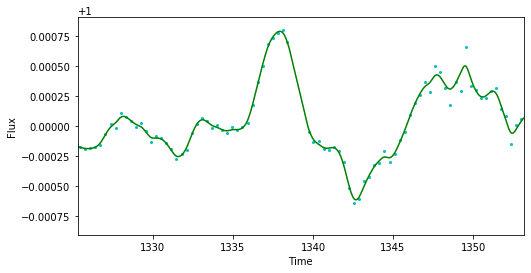

In [5]:
n_bin = int((max(tjd)-min(tjd))*12/nominal_width)
n_in_bin,bin_edges = np.histogram(tjd,bins=n_bin)
bin_indices = np.digitize(tjd,bin_edges)
t_bin = np.zeros(n_bin)
f_bin = np.zeros(n_bin)
e_bin = np.zeros(n_bin)
min_in_bin = 8
for i,n in enumerate(n_in_bin):
    if n > min_in_bin:
        t_bin[i] = mean(tjd[bin_indices == i+1])
        f_bin[i] = median(flux_r[bin_indices == i+1])
        e_bin[i] = 1.25*mean(abs(flux_r[bin_indices == i+1] - f_bin[i]))/sqrt(n)

mask_not_empty = (e_bin > 0)
t_bin = t_bin[mask_not_empty]
f_bin = f_bin[mask_not_empty]
e_bin = e_bin[mask_not_empty]

Q = 1.0
w0 = 1.0
S0 = np.var(f_bin) / (w0 * Q)
bounds = dict(log_S0=(-25, 25), log_Q=(-25, 25), log_omega0=(-25, 25))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
bounds = dict(log_sigma=(-25, 25))
kernel += terms.JitterTerm(log_sigma=-10,bounds=bounds)
gp = celerite.GP(kernel, mean=1)
gp.compute(t_bin, yerr=e_bin)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(f_bin)))
def neg_log_like(params, f_bin, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(f_bin)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
result_gp = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(f_bin, gp))
gp.set_parameter_vector(result_gp.x)
pred_mean = gp.predict(f_bin, tjd,return_cov=False,return_var=False)

fig1, ax1 = subplots(figsize=(8,4))
ax1.scatter(t_bin,f_bin,s=4,c='c')
ax1.plot(tjd, pred_mean, color='g')
ax1.set_xlim(min(tjd),max(tjd))
ax1.set_ylim(1-3*f_bin.std(),1+3*f_bin.std())
ax1.set_xlabel('Time')
ax1.set_ylabel('Flux')
flux = flux_r/pred_mean
ferr = ferr_r/pred_mean

#### Limb darkening
Use the coefficients of the four-parameter limb-darkening law from Claret 2018, [J/A+A/618/A20/TESSa](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/618/A20/TESSa) for Teff=4100, logg=4.5, [M/H]=0 to calculate h_1 and h_2 parameters for power-2 limb-darkening.


In [6]:
from pycheops.ld import ld_claret, ld_power2,h1h2_to_ca
a = [1.9393, -2.6425, 2.5569, -0.8485]
mu_Cri = 0.0535
t = ld_claret(np.array([mu_Cri,0.5/(1-mu_Cri)]),a)
h_1 = t[1]
h_2 = t[1]-t[0]   
print('h_1 = {:0.3f}'.format(h_1))
print('h_2 = {:0.3f}'.format(h_2))

h_1 = 0.753
h_2 = 0.422


#### Transit noise plot

Time steps is nominal transit width divided by over-sampling factor, over.

In [7]:
over = 8
ts = min(tjd)+nominal_width/48
te = max(tjd)-nominal_width/48
nt = over * int((max(tjd)-min(tjd))*24/nominal_width)
tt = linspace(ts, te, nt)
tn = []
tf = []
for t in tt:
    n_,f_ = transit_noise(tjd, flux, ferr, 
                      width=nominal_width, T_0 = t,
                      h_1=h_1, h_2=h_2)
    tn.append(n_)
    tf.append(f_)

Median 1-sigma transit depth = 30.8 ppm
Median error scaling factor = 1.176


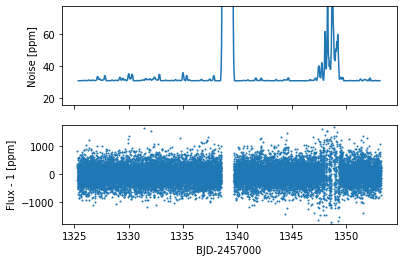

In [8]:
fig, ax = subplots(nrows=2,sharex=True)    
ax[0].plot(tt,tn)
ax[0].set_ylabel('Noise [ppm]')
ax[0].set_ylim(0.5*np.nanmedian(tn),2.5*np.nanmedian(tn))
ax[1].scatter(tjd, (flux-1)*1e6,s=1)
ax[1].set_ylabel('Flux - 1 [ppm]')
ax[1].set_xlabel('BJD-2457000')
ax[1].set_ylim(-5e6*flux.std(),5e6*flux.std())
D = np.nanmedian(tn)*1e-6
print('Median 1-sigma transit depth = {:0.1f} ppm'.format(np.nanmedian(tn)))
print('Median error scaling factor = {:0.3f}'.format(np.nanmedian(tf)))

#### Transit search
Calculate best-fit transit depth as a function of time over one orbital cycle.

Dotted line in output plot at +/- 3-sigma


(-1759.3112332330393, 1759.3112332330393)

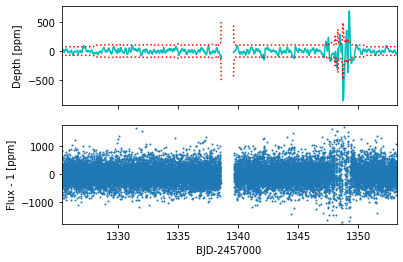

In [9]:
TM  = models.TransitModel()
b = 0.5   # Nominal transit width to use for calculation of transit profile
k = sqrt(D)
W = transit_width(1/aR.n,k,b)
nt = over * int(P.n*24/nominal_width)
tt = linspace(median(tjd), median(tjd)+P.n, nt)
td = []
te = []
for t in tt:
    p = TM.make_params(T_0=t, P=P.n, 
                       D=D, W=W, b=b,
                       h_1=h_1, h_2=h_2)
    model = TM.eval(params=p,t=tjd)
    s,_,e_s,_ = models.scaled_transit_fit(flux,ferr,model)
    td.append(s*D*1e6)
    te.append(e_s*D*1e6)

te = np.array(te)
fig, ax = subplots(nrows=2,sharex=True)   
cycle = np.round((tjd-median(tjd))/P.n)
for c in range(int(min(cycle)),int(max(cycle))):
    ax[0].plot(tt+c*P.n,td,c='c')
    ax[0].plot(tt+c*P.n,3*te,ls=':',c='r')
    ax[0].plot(tt+c*P.n,-3*te,ls=':',c='r')
ax[0].set_ylabel('Depth [ppm]')
ax[1].scatter(tjd, (flux-1)*1e6,s=1)
ax[1].set_ylabel('Flux - 1 [ppm]')
ax[1].set_xlabel('BJD-2457000')
ax[1].set_xlim(min(tjd),max(tjd))
ax[1].set_ylim(-5e6*flux.std(),5e6*flux.std())


#### Monte Carlo calculation
Randomly generate transit time, impact parameter, etc. then calculate the best-fit transit depth and its error in a loop. 

For each loop iteration, randomly sample from the stellar radius distribution and the depth error distribution to get a sample of  planet radii.

In [10]:
percentile = 68.3
nmc = 500
nsample = 50
rpl = []
k = sqrt(D)
TM  = models.TransitModel()
for i in range(0,nmc):
    _T0 = G(T0.n,T0.s)
    _P = G(P.n,P.s)
    _aR = G(aR.n,aR.s)
    b = U() 
    W = transit_width(1/_aR,k,b)
    p = TM.make_params(T_0=_T0, P=_P, 
                       D=D, W=W, b=b,
                       h_1=h_1, h_2=h_2)
    model = TM.eval(params=p,t=tjd)
    s,_,e_s,_ = models.scaled_transit_fit(flux,ferr,model)
    d = s*D
    e_d = e_s*D
    rpl.append(sqrt(clip(G(d,e_d,nsample),0,1))*G(r_star.n,r_star.s,nsample))
    #print("{:5.0f} {:10.4f} {:5.2f} {:4.2f} {:4.2f} {:4.2f}".format(i,_T0,_aR,b,d*1e6,e_d*1e6))

rpl = np.array(rpl).flatten()
rpl = rpl*R_SunN/R_EarthN
nok = sum(isfinite(rpl))
rmax = max(rpl[isfinite(rpl)])
pok = 100*nok/len(rpl)
print("Probability of missed transit = {:0.1f}%".format(100-pok))
if  pok < percentile:
    print("Insufficient data to calculate {}%-ile upper limit".format(percentile))
else:
    rpl[isnan(rpl)] = rmax
    rpl_up = np.percentile(rpl,percentile)
    print("{}%-ile upper limit to planet radius = {:0.2f} R_Earth".
          format(percentile,rpl_up))

Probability of missed transit = 21.4%
68.3%-ile upper limit to planet radius = 0.57 R_Earth


##### Cumulative distribution of R$_{\rm pl}$ values
Indeterminate values (where the transits coincide with a gaps in the data) are lumped into the last bin.

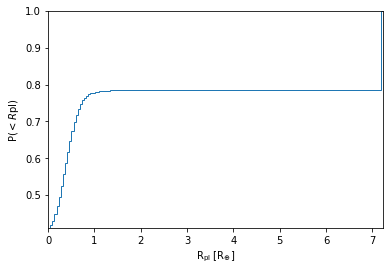

In [11]:
fig, ax = plt.subplots()
n,_,_ = ax.hist(rpl, int(sqrt(nmc*nsample)), histtype='step',cumulative=True,density=True)
ax.set_xlim(0,rmax)
ax.set_ylim(min(n),1)
ax.set_xlabel(r'R$_{\rm pl}$ [R$_{\oplus}$]')
ax.set_ylabel(r'P($< R{\rm pl}$)');

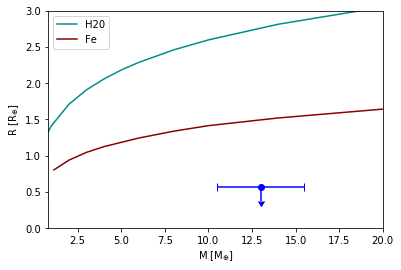

In [12]:
Fe = array(
    [[1.14, 0.802], [2.0, 0.936], [3.0, 1.043],
     [4.0, 1.122], [6.0, 1.241], [8.0, 1.335],
     [10.0, 1.412], [14.0, 1.518],[20.0, 1.640]])
H20 = array([
    [0.702, 1.280], [1.0, 1.412],[2.0, 1.707],[3.0, 1.905],
    [4.0, 2.055],[5.0, 2.180],[6.0, 2.284],[8.0, 2.457],
    [10.0, 2.595], [14.0, 2.811], [20.0, 3.049]])
fig, ax = subplots()
ax.plot(H20[:,0],H20[:,1],c='darkcyan',label='H20')
ax.plot(Fe[:,0],Fe[:,1],c='darkred',label='Fe')
ax.set_xlim(0.8,20)
ax.set_ylim(0,3)
ax.set_xlabel('M [M$_{\oplus}$]')
ax.set_ylabel('R [R$_{\oplus}$]')
ax.plot(mpl.n,rpl_up,'bo')
ax.errorbar(mpl.n,rpl_up,xerr=mpl.s,c='b',capsize=4)    
ax.errorbar(mpl.n,rpl_up,yerr=0.2,c='b',uplims=True)
ax.legend()

&copy; Pierre Maxted, Keele University (2020)